# Table: Neural

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from figures.tables import table_neural
from figures.box import plot_box

pal_model, pal_cat = get_palette()

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
skip_fits = [
    'fixate2_nf-420_beta-0.15_(2023_04_27,13:57)',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15)',
]
category2latex = {
    'fixate0': '\\fixate{0}',
    'fixate1': '\\fixate{1}',
    'obj1': '\\obj{1}',
}

def _info(fit):
    info = fit.split('_')
    i = info.index([
        e for e in info
        if 'nf-' in e
    ].pop())
    category = info[i - 1]
    nf = int(info[i].split('-')[1])
    beta = info[i + 1].split('-')[1]
    try:
        beta = float(beta)
    except ValueError:
        beta = str(beta)
    tag = 'VAE' if 'vanilla' in info else 'cNVAE'
    if beta == 'ae':
        tag = tag.replace('V', '')
    return category, nf, beta, tag

## Path

In [3]:
path = pjoin(tmp_dir, 'results_combined')

In [4]:
fits = []
with open(pjoin(path, 'fits.txt'), 'r') as f:
    for line in f:
        if '# computer name' in line:
            continue
        fits.append(line.split('\n')[0])

## Load to df

In [5]:
df_neural = []
for fit in fits:
    if 'reservoir' in fit or fit in skip_fits:
        continue
    category, nf, beta, tag = _info(fit)    
    if beta in [0.001, 20.0]:
        continue

    # load df
    _df = f"summary_{fit}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    assert len(_df) == 141
    _df.insert(0, 'model', tag)
    df_neural.append(_df)

df_neural = pd.concat(df_neural).reset_index()
betas = ['ae'] + sorted([
    b for b in df_neural['beta'].unique()
    if isinstance(b, float)
])

## Table without pool

In [6]:
cats = {
    'cNVAE': ['fixate1', 'fixate0', 'obj1'],
    'VAE': ['fixate1'],
    'cNAE': ['fixate1'],
    'AE': ['fixate1'],
}
table = table_neural(
    df=df_neural,
    cats=cats,
    betas=[0.5, 0.8, 1, 5],
)
print(table)

cNVAE & \fixate{1} & $\mathbf{0.506 \pm 0.018}$ & $\mathbf{0.517 \pm 0.017}$ & $0.494 \pm 
0.018$ & $0.486 \pm 0.016$ \\
& \fixate{0} & $0.428 \pm 0.018$ & $0.450 \pm 0.019$ & $0.442 \pm 0.019$ & $0.469 \pm 0.018$ 
\\
& \obj{1} & $0.471 \pm 0.018$ & $0.465 \pm 0.018$ & $0.477 \pm 0.017$ & $0.468 \pm 0.018$ \\
VAE & \fixate{1} & $\mathbf{0.508 \pm 0.019}$ & $0.481 \pm 0.018$ & $0.494 \pm 0.018$ & 
$\mathbf{0.509 \pm 0.018}$ \\
cNAE & \fixate{1} & $0.476 \pm 0.018$ \\
AE & \fixate{1} & $0.495 \pm 0.019$ \\

## Box

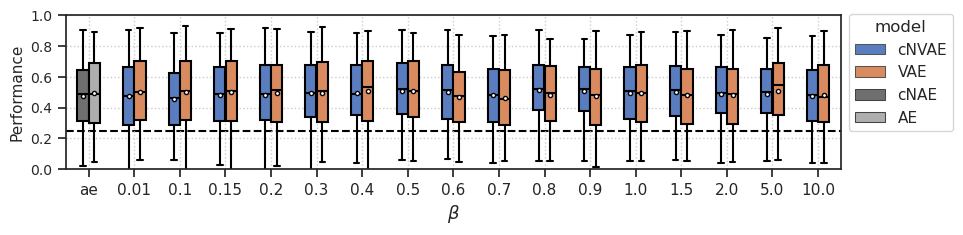

In [7]:
fig, ax = plot_box(df_neural, 'perf', 'Performance', display=False)
ax.axhline(0.251, color='k', ls='--', zorder=0)
display(fig)

In [8]:
fig.savefig(pjoin(fig_base_dir, 'neural_perf.pdf'), **kws_fig)
fig.savefig(pjoin(fig_base_dir, 'neural_perf.png'), **kws_fig)

## Point

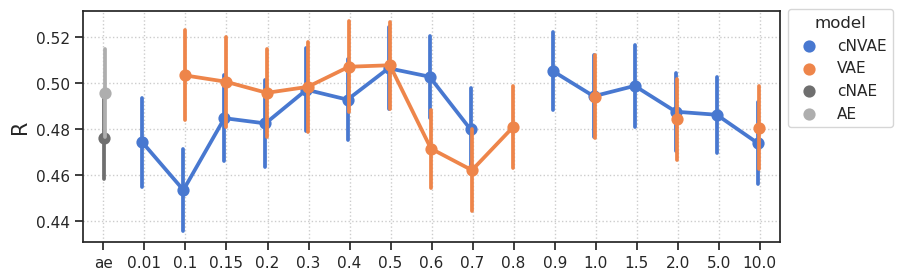

In [10]:
_df = df_neural.loc[df_neural['category'] == 'fixate1']

fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=_df,
    x='beta',
    y='perf',
    hue='model',
    order=betas,
    errorbar='se',
    palette=pal_model,
    dodge=True,
    ax=ax,
)
# ax.set_ylim(0.23, 0.54)
# ax.axhline(0.251, color='dimgrey', ls='--')
ax.set_ylabel('R', fontsize=15)
ax.set_xlabel('')
ax.grid()

leg = ax.get_legend()
if leg is not None:
    leg.set_bbox_to_anchor((1.0, 1.04))

plt.show()a

## R2

In [82]:
df_r2 = collections.defaultdict(list)
for fit in tqdm(fits):
    if 'reservoir' in fit:
        continue
    if fit == 'fixate2_nf-420_beta-0.15_(2023_04_27,13:57)':
        continue
    category, nf, beta, tag = _info(fit)    
    if beta == 20.0:
        continue

    # load df
    _df = f"summary-all_{fit}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    _df = _df.loc[~np.isnan(_df['r2_tst'])]
    _df.drop(columns='index', inplace=True)

    # pick best r2
    looper = itertools.product(
        sorted(_df['expt'].unique()),
        sorted(_df['cell'].unique()),
    )
    for expt, cell in looper:
        _df1 = _df.loc[
            (_df['expt'] == expt) &
            (_df['cell'] == cell)
        ]
        if not len(_df1):
            continue
        best_i = _df1['r2_tst'].argmax()
        best = _df1.iloc[best_i]
        best_r2 = best['r2_tst'] / best['max_r2']
        if best_r2 < 0:
            best_r2 = np.nan
#        best_r2 = np.maximum(0, best_r2)

        df_r2['model'].append(tag)
        df_r2['category'].append(category)
        df_r2['nf'].append(nf)
        df_r2['beta'].append(beta)
        df_r2['expt'].append(expt)
        df_r2['cell'].append(cell)
        df_r2['id'].append(f"{expt}_{cell}")
        df_r2['r2'].append(best_r2)

df_r2 = pd.DataFrame(df_r2)

100%|██████████| 65/65 [00:27<00:00,  2.35it/s]


In [83]:
_df = df_r2.loc[df_r2['category'] == 'fixate1']

<Axes: xlabel='r2', ylabel='Count'>

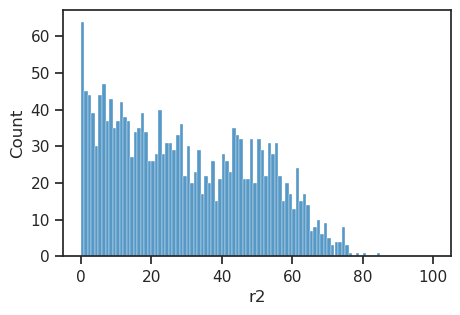

In [84]:
sns.histplot(_df['r2'], bins=np.linspace(0, 100, 101))

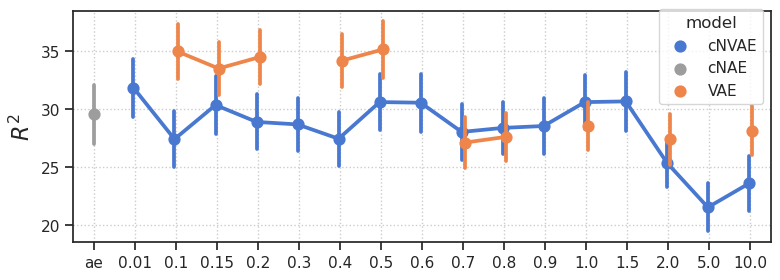

In [85]:
_df = df_r2.loc[df_r2['category'] == 'fixate1']

fig, ax = create_figure(1, 1, (9, 3))
sns.pointplot(
    data=_df,
    x='beta',
    y='r2',
    hue='model',
    order=betas,
    errorbar='se',
    palette=pal,
    dodge=True,
    ax=ax,
)
ax.set_ylabel(r'$R^2$', fontsize=16)
ax.set_xlabel('')
ax.grid()

leg = ax.get_legend()
if leg is not None:
    leg.set_bbox_to_anchor((1.0, 1.04))

plt.show()

In [11]:
_df = df.loc[
    (df['beta'] == 0.5) &
    (df['model'] == 'cNVAE') &
    (df['category'] == 'fixate1')
]

In [12]:
mu, sd = _df['perf'].mean(), _df['perf'].std()

In [13]:
ci = 0.95
dof = len(_df) - 1
se = sd / np.sqrt(dof + 1)
t_val = sp_stats.t.ppf((1 + ci) / 2, dof)

In [14]:
mu, se

(0.506407191271519, 0.01772121235584274)

In [15]:
mu - se * t_val, mu + se * t_val

(0.47137140246680975, 0.5414429800762283)

In [16]:
mu - se, mu + se

(0.4886859789156763, 0.5241284036273618)

## Table (with $R^2$ in mind)

In [11]:
beta = 0.5

looper = {
    'cNVAE': ['obj1', 'fixate0', 'fixate1', 'fixate2', 'transl1', 'transl2'],
    'VAE': ['fixate1'],
    'cNAE': ['fixate1'],
    'AE': ['fixate1'],
}
table = ''
for model, cat_list in looper.items():
    looper_beta = ['pool']
    if model in ['cNVAE', 'VAE']:
        looper_beta.insert(0, beta)
    for b in looper_beta:
        first_row_added = False
        for cat in cat_list:
            _df = df.loc[
                (df['model'] == model) &
                (df['category'] == cat)
            ]
            if not len(_df):
                continue

            mu = _df.groupby(['beta']).mean()
            sd = _df.groupby(['beta']).std()
            mu, sd = dict(mu['perf']), dict(sd['perf'])

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                _df = _df.pivot(columns='beta', values='perf')
            assert len(_df) == 141

            mu['pool'] = _df.max(1).mean()
            sd['pool'] = _df.max(1).std() 
            
            se = {
                k: v / np.sqrt(len(_df))
                for k, v in sd.items()
            }
            
            r_str = f"${mu[b]:0.3f} \\pm {se[b]:0.3f}$"
            # r2_str = TODO

            if first_row_added:
                table += f"& {cat} & {r_str} & - \\\\\n"
            else:
                if model == 'cNVAE':
                    model_str = f"{'{'}{model}\\\\ $(\\beta = {b})${'}'} "
                elif model == 'VAE':
                    model_str = f"{'{'}{model} $(\\beta = {b})${'}'} "
                else:
                    model_str = f"{model} "
                table += model_str + f"& {cat} & {r_str} & - \\\\\n"
                first_row_added = True

In [12]:
print(table)

{cNVAE\\ $(\beta = 0.5)$} & obj1 & $0.471 \pm 0.018$ & - \\
& fixate0 & $0.428 \pm 0.018$ & - \\
& fixate1 & $0.506 \pm 0.018$ & - \\
& fixate2 & $0.466 \pm 0.017$ & - \\
& transl1 & $0.500 \pm 0.018$ & - \\
& transl2 & $0.480 \pm 0.017$ & - \\
{cNVAE\\ $(\beta = pool)$} & obj1 & $0.530 \pm 0.018$ & - \\
& fixate0 & $0.547 \pm 0.019$ & - \\
& fixate1 & $0.586 \pm 0.019$ & - \\
& fixate2 & $0.539 \pm 0.018$ & - \\
& transl1 & $0.574 \pm 0.019$ & - \\
& transl2 & $0.544 \pm 0.018$ & - \\
{VAE $(\beta = 0.5)$} & fixate1 & $0.508 \pm 0.019$ & - \\
{VAE $(\beta = pool)$} & fixate1 & $0.573 \pm 0.019$ & - \\
cNAE & fixate1 & $0.476 \pm 0.018$ & - \\

In [13]:
cat2latex = {
    'fixate0': '\\fixatezero',
    'fixate1': '\\fixateone',
    'fixate2': '\\fixatetwo',

    'transl0': '\\translzero',
    'transl1': '\\translone',
    'transl2': '\\transltwo',

    'obj1': '\\objone',

}
for k, v in cat2latex.items():
    table = table.replace(k, v)

In [14]:
print(table)

{cNVAE\\ $(\beta = 0.5)$} & \objone & $0.471 \pm 0.018$ & - \\
& \fixatezero & $0.428 \pm 0.018$ & - \\
& \fixateone & $0.506 \pm 0.018$ & - \\
& \fixatetwo & $0.466 \pm 0.017$ & - \\
& \translone & $0.500 \pm 0.018$ & - \\
& \transltwo & $0.480 \pm 0.017$ & - \\
{cNVAE\\ $(\beta = pool)$} & \objone & $0.530 \pm 0.018$ & - \\
& \fixatezero & $0.547 \pm 0.019$ & - \\
& \fixateone & $0.586 \pm 0.019$ & - \\
& \fixatetwo & $0.539 \pm 0.018$ & - \\
& \translone & $0.574 \pm 0.019$ & - \\
& \transltwo & $0.544 \pm 0.018$ & - \\
{VAE $(\beta = 0.5)$} & \fixateone & $0.508 \pm 0.019$ & - \\
{VAE $(\beta = pool)$} & \fixateone & $0.573 \pm 0.019$ & - \\
cNAE & \fixateone & $0.476 \pm 0.018$ & - \\

## Table (old, contaiend beta pool)

In [ ]:
which_betas = [0.5, 0.8, 1, 5]

looper = {
    'cNVAE': ['obj1', 'fixate0', 'fixate1'],
    # ['obj1', 'fixate0', 'fixate1', 'fixate2', 'transl1', 'transl2'],
    'VAE': ['fixate1'],
    'cNAE': ['fixate1'],
    'AE': ['fixate1'],
}
table = ''
for model, cat_list in looper.items():
    first_row_added = False
    for cat in cat_list:
        _df = df_neural.loc[
            (df_neural['model'] == model) &
            (df_neural['category'] == cat)
        ]
        if not len(_df):
            continue

        mu = _df.groupby(['beta']).mean()
        sd = _df.groupby(['beta']).std()
        mu, sd = dict(mu['perf']), dict(sd['perf'])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            _df = _df.pivot(columns='beta', values='perf', index='index')
        assert len(_df) == 141

        mu['pool'] = _df.max(1).mean()
        sd['pool'] = _df.max(1).std()
        se = {
            k: v / np.sqrt(len(_df))
            for k, v in sd.items()
        }

        if 'VAE' in model:
            r_str = []
            for b in which_betas:
                if mu[b] > 0.5:
                    r_str.append(f"$\mathbf{'{'}{mu[b]:0.3f} \\pm {se[b]:0.3f}{'}'}$")
                else:
                    r_str.append(f"${mu[b]:0.3f} \\pm {se[b]:0.3f}$")
        else:
            r_str = [' - '] * len(which_betas)
        r_str = ' & '.join(r_str)
        
        if mu['pool'] > 0.57:
            r_str_pool = f"$\mathbf{'{'}{mu['pool']:0.3f} \\pm {se['pool']:0.3f}{'}'}$"
        else:
            r_str_pool = f"${mu['pool']:0.3f} \\pm {se['pool']:0.3f}$"

        if first_row_added:
            table += f"& {cat} & {r_str} & {r_str_pool} \\\\\n"
        else:
            model_str = f"{model} "
            table += model_str + f"& {cat} & {r_str} & {r_str_pool} \\\\\n"
            first_row_added = True